In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [20]:
#load the idx files of fasion mnist

import struct

def load_images(file):
    with open(file, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)
        return data

def load_labels(file):
    with open(file, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

train_images = load_images("train-images-idx3-ubyte")
train_labels = load_labels("train-labels-idx1-ubyte")

test_images = load_images("t10k-images-idx3-ubyte")
test_labels = load_labels("t10k-labels-idx1-ubyte")

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [21]:
#creating a pytorch datasetr as we are using and implementing the pytorch dataset

class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.x = torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 255.0
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_ds = FashionMNISTDataset(train_images, train_labels)
test_ds = FashionMNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


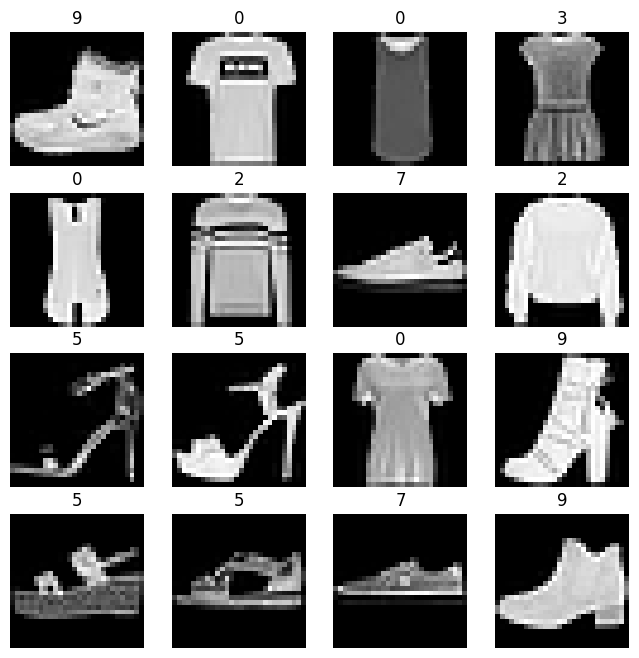

In [22]:
#visulaize the samples of the pytorch dataset

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(train_labels[i])
    plt.axis("off")
plt.show()


In [23]:
#creating a simple basic model with fully conncetd neurla network

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.fc(x)

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
#training the fuction for the newly created neural network

def train_model(model, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")

train_model(model, epochs=5)


Epoch 1/5 | Loss: 488.9288
Epoch 2/5 | Loss: 358.7170
Epoch 3/5 | Loss: 319.4125
Epoch 4/5 | Loss: 295.0235
Epoch 5/5 | Loss: 276.9255


In [25]:
#evaluating the newly created models accuracy

def test_accuracy(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += len(y)
    print(f"Accuracy: {correct / total * 100:.2f}%")

test_accuracy(model)


Accuracy: 87.21%


In [26]:
#now designing the cnn architecture for the gray scaled images

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

cnn = CNN()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)


In [27]:
#training the cnn for optimized results

train_model(cnn, epochs=5)
test_accuracy(cnn)


Epoch 1/5 | Loss: 465.3638
Epoch 2/5 | Loss: 303.7878
Epoch 3/5 | Loss: 263.5431
Epoch 4/5 | Loss: 236.2315
Epoch 5/5 | Loss: 216.0174
Accuracy: 91.20%


In [28]:
#creating a residual block

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return torch.relu(x + self.conv(x))


In [29]:
#building the resnet model for the cn architecture

class MiniResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(32),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(64),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.fc(x)

resnet = MiniResNet()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)


In [30]:
#traig the resnet model

train_model(resnet, epochs=8)
test_accuracy(resnet)


Epoch 1/8 | Loss: 391.8044
Epoch 2/8 | Loss: 255.6212
Epoch 3/8 | Loss: 222.6175
Epoch 4/8 | Loss: 195.6481
Epoch 5/8 | Loss: 175.7157
Epoch 6/8 | Loss: 159.0356
Epoch 7/8 | Loss: 145.5214
Epoch 8/8 | Loss: 131.1702
Accuracy: 93.32%


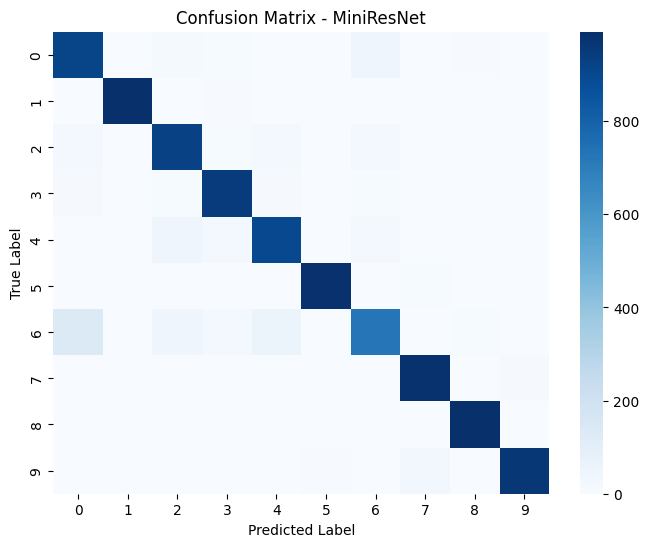

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.88      0.93      0.90      1000
           3       0.93      0.95      0.94      1000
           4       0.90      0.90      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.87      0.72      0.79      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [31]:
#confusion marix for showcasing model performance

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        preds = resnet(x).argmax(1)
        y_true.extend(y.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - MiniResNet")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print(classification_report(y_true, y_pred))
